In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# How to edit morphologies

`Jaxley` provides functionality to edit morphologies. If you edit morphologies, please do so _before_ you change the number of compartments per branch (via, e.g., `cell.branch(0).set_ncomp(4)`), _before_ you insert channels, recordings, and stimuli, and _before_ you make parameters trainable.

## Deleting parts of a morphology

Below, we will show how you can delete all apical branches of a morphology.

In [66]:
import jaxley as jx
from jaxley.io.morph_utils import morph_delete

fname = "../../tests/swc_files/morph_ca1_n120.swc"
cell = jx.read_swc(fname, ncomp=1)
cell.compute_compartment_centers()

# This creates a new cell which has the apical dendrite deleted.
cell = morph_delete(cell.apical)

In [67]:
graph = to_graph(cell)

In [68]:
from jaxley.io.graph import build_compartment_graph, vis_compartment_graph

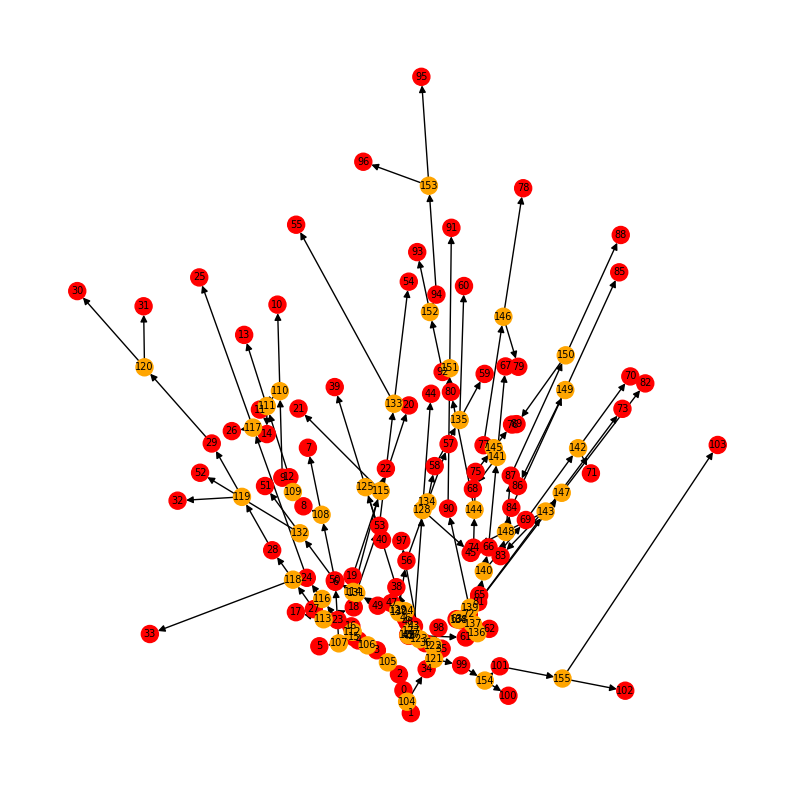

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
_ = vis_compartment_graph(graph, ax=ax)

In [71]:
swc_graph = to_swc_graph(fname)
comp_graph = build_compartment_graph(swc_graph, ncomp=1)

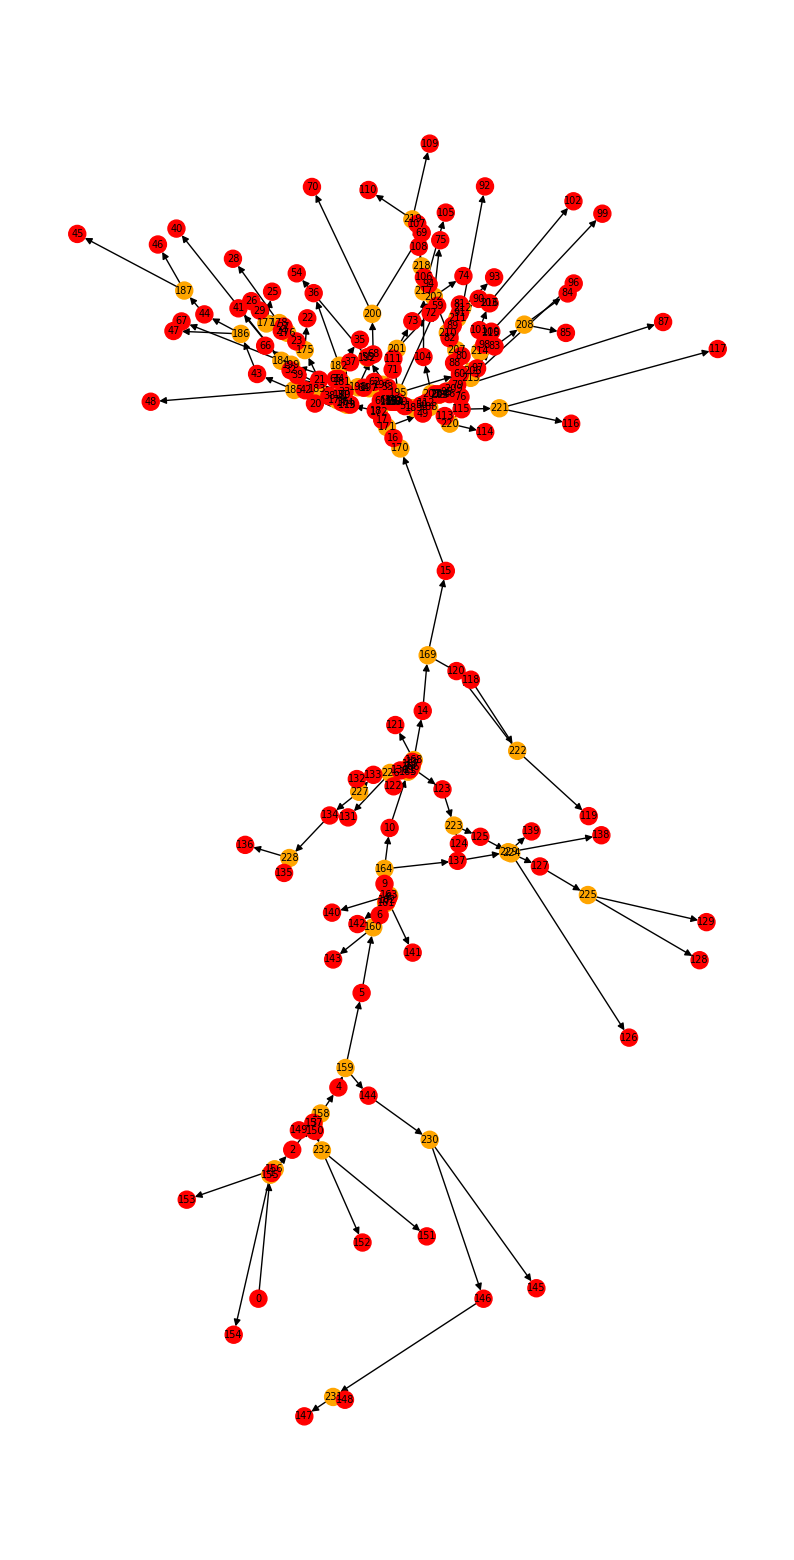

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(10, 20))
vis_compartment_graph(comp_graph, ax=ax)

To check if everything worked, we visualize the resulting morphology:

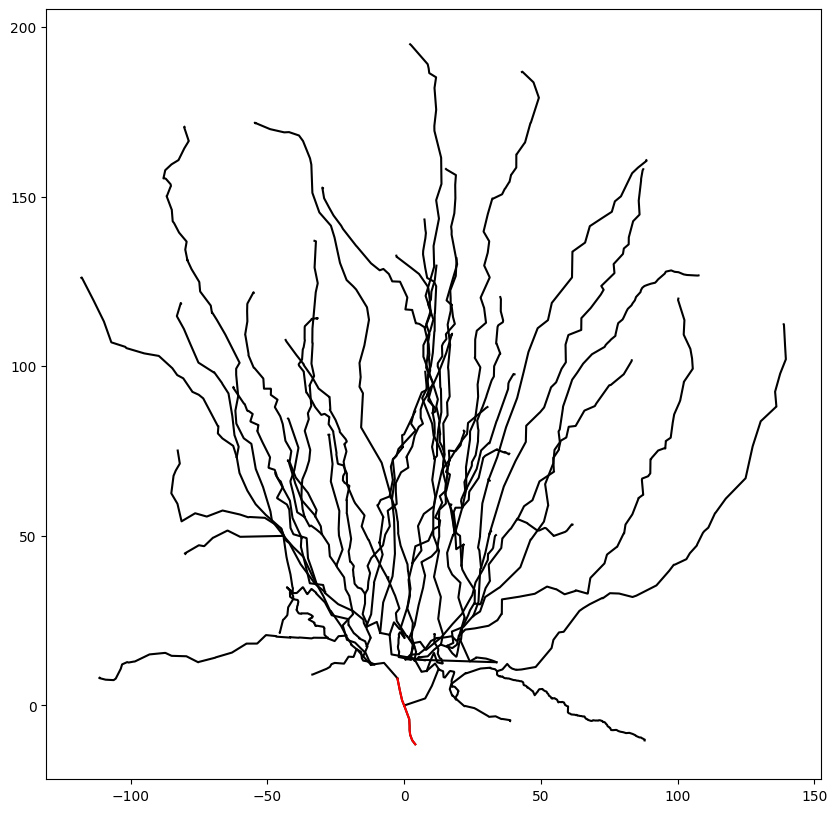

In [61]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = cell.vis(ax=ax)
ax = cell.soma.vis(ax=ax, color="r")

## Attaching two morphologies

In [4]:
from jaxley.io.graph import connect_graphs, vis_compartment_graph

In [5]:
# pos = {k: (v["x"], v["y"]) for k, v in comp_graph.nodes.items()}
# nx.draw(comp_graph, pos=pos, with_labels=True,)

In [40]:
import numpy as np
import networkx as nx
from jaxley.io.graph import to_graph, from_graph, to_swc_graph, build_compartment_graph
import jaxley as jx

fname = "../../tests/swc_files/morph_ca1_n120_250.swc"
original_cell = jx.read_swc(fname, ncomp=1)
original_cell.compute_compartment_centers()

comp = jx.Compartment()
branch = jx.Branch(comp, ncomp=1)
stub = jx.Cell(branch, parents=[-1, 0])
stub.branch("all").set("length", 30.0)
stub.compute_xyz()
stub.move(20, 0, 0)
stub.compute_compartment_centers()

In [32]:
from jaxley.io.morph_utils import morph_attach

cell = morph_attach(original_cell.branch(0).comp(1), stub.branch(0).comp(0))

comps [0, 0]


In [33]:
# stub_graph = to_graph(stub)
# cell_graph = to_graph(original_cell)

# fig, ax = plt.subplots(1, 1, figsize=(4, 2))
# vis_comp_graph(comp_graph, ax=ax)
# vis_comp_graph(stub_graph, ax=ax)
# node1 = "n0"
# node2 = "n0"

In [34]:
# combined_graph = connect_graphs(cell_graph, stub_graph, 8, 0)

In [35]:
# vis_comp_graph(combined_graph)

In [36]:
# cell = from_graph(combined_graph)

In [38]:
# cell.nodes

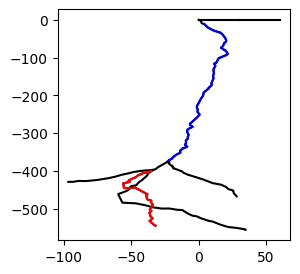

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
_ = cell.vis(ax=ax)
_ = original_cell.branch(1).vis(ax=ax, color="b")
_ = cell.branch(10).vis(ax=ax, color="r")
# _ = ax.scatter(-3.49, -98.9)

In [338]:
cell.delete_recordings()
cell.delete_stimuli()
cell.soma.branch(0).comp(0).record()
cell.soma.branch(0).comp(0).stimulate(jx.step_current(10.0, 20.0, 0.1, 0.025, 100.0))

Added 1 recordings. See `.recordings` for details.
Added 1 external_states. See `.externals` for details.


In [339]:
v = jx.integrate(cell)

In [340]:
v[0, 0]

Array(-70., dtype=float32)

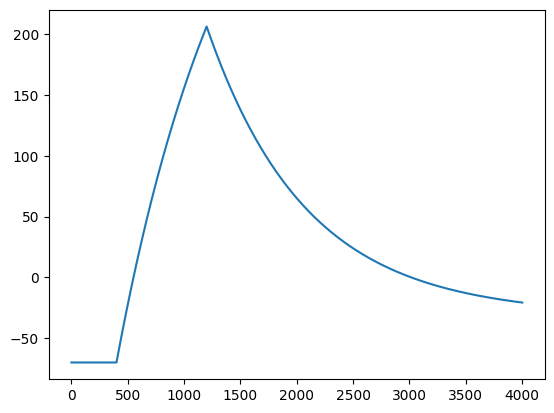

In [341]:
plt.plot(v.T)

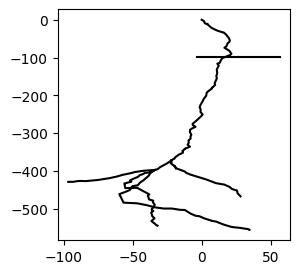

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
_ = cell.vis(ax=ax)

## Graph-backend for more flexibility

All of the above is achieved by using `Jaxley`'s "graph-backend", which is based on `networkX`. As such, you can modify `Jaxley` morphologies with any feature of the [networkX](https://networkx.org) toolkit.

For more details on `Jaxley`'s graph-backend, see [this tutorial](https://jaxley.readthedocs.io/en/latest/tutorials/08_importing_morphologies.html). Below, as an example, we will trim all tip dendrites that are shorter than 100 $\mu$m.

In [24]:
from jaxley.io.graph import swc_to_graph, build_compartment_graph, vis_comp_graph

fname = "../../tests/swc_files/morph_ca1_n120_250.swc"
swc_graph = swc_to_graph(fname)
comp_graph = build_compartment_graph(swc_graph, ncomp=1)

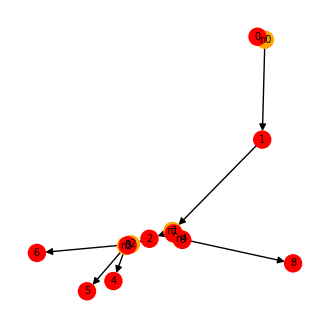

In [25]:
vis_comp_graph(comp_graph)

In [26]:
nodes_to_keep = []
for node in comp_graph.nodes:
    degree = comp_graph.in_degree(node) + comp_graph.out_degree(node)
    if degree > 1 or comp_graph.nodes[node]["length"] > 150.0 or "soma" in comp_graph.nodes[node]["groups"]:
        nodes_to_keep.append(node)

comp_graph = nx.subgraph(comp_graph, nodes_to_keep)

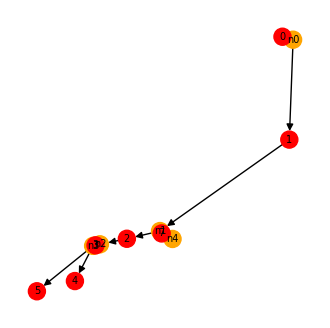

In [27]:
vis_comp_graph(comp_graph)

In [28]:
cell = from_graph(comp_graph)

In [29]:
cell.delete_recordings()
cell.delete_stimuli()
cell.soma.branch(0).comp(0).record()
cell.soma.branch(0).comp(0).stimulate(jx.step_current(10.0, 20.0, 0.1, 0.025, 100.0))

Added 1 recordings. See `.recordings` for details.
Added 1 external_states. See `.externals` for details.


In [30]:
v = jx.integrate(cell)

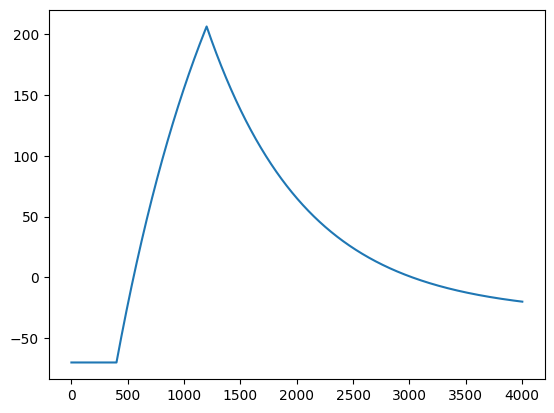

In [31]:
plt.plot(v.T)